In [2]:
!pip install implicit -qqq
!pip install catboost -qqq

In [3]:
import datetime
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import scipy.sparse as sparse

from catboost import CatBoostClassifier
import implicit
import warnings; warnings.filterwarnings('ignore')

## <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#232834"><b><span style='color:#686dec'>2 |</span></b> <b>KION Dataset</b></div>

Просмотры фильмов и сериалов в приложении KION:

- данные взаимодействий пользователя с товарами (фильмы) `interactions`
- данные о пользователях `users`
- данные об айтемах (фильмы, сериалы и т.д.) `items`

In [5]:
interactions = pd.read_csv("/kaggle/input/kion-data/interactions_df.csv")
items = pd.read_csv("/kaggle/input/kion-data/items.csv")
users = pd.read_csv("/kaggle/input/kion-data/users.csv")

In [6]:
# обработка даты
interactions['last_watch_dt'] = pd.to_datetime(interactions['last_watch_dt']).map(lambda x: x.date())

print(f"Уникальных юзеров в interactions: {interactions['user_id'].nunique()}")
print(f"Уникальных айтемов в interactions: {interactions['item_id'].nunique()}")

Уникальных юзеров в interactions: 962179
Уникальных айтемов в interactions: 15706


### <b><span style='color:#686dec'>Данные о взаимодействий пользователях с фильмами </span></b>

Как и ранше у нас стандартые фичи
- `user_id` : пользователь
- `item_id` : фильм 

У нас есть фича времени последнего запуска фильма 

- `last_watch_dt` дата просмотра

И фичи взаимодействий:

- `total_dur` длительность просмотра
- `watched_pct` доля просмотра в %

Будем использовать эти данные как основной источник данных для формирования рекомендации

In [7]:
interactions.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


### <b><span style='color:#686dec'>Данные о товарах
</span></b>

Данные о самих товарах

- `content_type` - тип контента
- `title` - название на русском
- `title_orig` - название оригинальное
- `release_year` - год выпуска
- `countries` - страны
- `for_kids` - флаг контент для детей
- `age_rating`- Возрастной рейтинг
- `studios` - студии
- `directors` - режиссеры
- `actors`- актеры
- `keywords` - ключевые слова
- `description` - описание

In [8]:
items.head()

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю..."
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,NaN,12.0,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж..."



### <b><span style='color:#686dec'>Данные о пользователях</span></b>

Все признаки - результат предсказания соцдем моделей

- `age` : Возростная группа 
- `income` : Группа дохода пользователя 
- `sex` : Пол пользователя
- `kids_flg` : флаг наличия детей


In [9]:
users.head()

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0


In [10]:
"""

Preprocessing

- Filter from [interactions] views with less than 300 second views
- Filter [users] (user_id) who have less than 10 film views
- Filter out [movies] (item_id) which have less than 10 film views

"""

'\n\nPreprocessing\n\n- Filter from [interactions] views with less than 300 second views\n- Filter [users] (user_id) who have less than 10 film views\n- Filter out [movies] (item_id) which have less than 10 film views\n\n'

## <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#232834"><b><span style='color:#686dec'>3 |</span></b> <b>Preprocessing</b></div>

### <b><span style='color:#686dec'>1) Фильтруем случайные просмотры</span></b>

Не будем использовать все данные, на первой стадий отфильруем случайные просмотры из `interactions`

In [11]:
# Не будем использовать все данные, на первой стадий отфильруем случайные просмотры из interactions
interactions = interactions[interactions['total_dur'] >= 300]

### <b><span style='color:#686dec'>2) Фильтрация пользователей</span></b>

Далее отфильтруем конкретных фользователей из выборки, нас интересуют только те пользователи у которых 10 или больше просмотров

In [12]:
user_interactions_count = interactions.groupby('user_id')[['item_id']].count().reset_index()
filtered_users = user_interactions_count[user_interactions_count['item_id'] >= 10][['user_id']]
interactions = filtered_users.merge(interactions, how='left')

### <b><span style='color:#686dec'>3) Фильтрация фильмов</span></b>

Далее будем фильтровать уже по фильмам, нас интересуют только фильмы у которых больше 10 просмотров вреди всех пользователей

In [13]:
item_interactions_count = interactions.groupby('item_id')[['user_id']].count().reset_index()
filtered_items = item_interactions_count[item_interactions_count['user_id'] >= 10][['item_id']]
interactions = filtered_items.merge(interactions, how='left')

## <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#232834"><b><span style='color:#686dec'>4 |</span></b> <b>Train/Test Splitting</b></div>

### <b><span style='color:#686dec'>Диапазоны времени</span></b>

Так как мы будем разбивать выборку на части используя время, найдем диапазоны которые содержатся в данных

In [14]:
max_date = interactions['last_watch_dt'].max()
min_date = interactions['last_watch_dt'].min()

print(f"min дата в interactions: {min_date}")
print(f"max дата в interactions: {max_date}")

min дата в interactions: 2021-03-13
max дата в interactions: 2021-08-22


- [test] : содержит последние 7 дней взаимодействий 

- [train_val] : train & validation dataset <= 7 days
- [train_val] then split into two :
    - [train] up to last 60 days of interactions (to test start date)
    - [val] last 60 days of interactions (to test start date)


In [15]:
test_threshold = max_date - pd.Timedelta(days=7)
val_threshold = test_threshold - pd.Timedelta(days=60) # два месяца для обучения модели второго уровня

test = interactions[(interactions['last_watch_dt'] >= test_threshold)]
train_val = interactions[(interactions['last_watch_dt'] < test_threshold)]

val = train_val[(train_val['last_watch_dt'] >= val_threshold)]
train = train_val[(train_val['last_watch_dt'] < val_threshold)]

print(f"train: {train.shape}")
print(f"val: {val.shape}")
print(f"test: {test.shape}")

train: (881660, 5)
val: (1246263, 5)
test: (172593, 5)


## <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#232834"><b><span style='color:#686dec'>5 |</span></b> <b>Stage 1 Model : BPR Matrix Decomposition </b></div>

- [val] : must contain users found in [train]
- [train] : used to train first level model

- use [train] to create an initial selection of user recommendations
  for each user we select 30 items for each user, stored in [pred_bpr]
  
- Having created recommendations using [train], we compare them with 
  the films they watched in the validation dataset (ie future) and 
  evaluate metrics

In [17]:
# В val выборке должны быть пользователи которые были в train
print(val.shape)
val = val[val['user_id'].isin(train['user_id'].unique())]
print(val.shape)

(1246263, 5)
(694032, 5)


In [18]:
# train model on [train]
users_id = list(np.sort(train.user_id.unique()))
items_train = list(train.item_id.unique())
ratings_train = list(train.watched_pct)

rows_train = train.user_id.astype('category').cat.codes
cols_train = train.item_id.astype('category').cat.codes

train_sparse = sparse.csr_matrix((ratings_train, (rows_train, cols_train)), 
                                 shape=(len(users_id), len(items_train)))

algo = implicit.bpr.BayesianPersonalizedRanking(factors=50, 
                                                regularization=0.01, 
                                                iterations=50, 
                                                use_gpu=False)
algo.fit((train_sparse).astype('double'))

  0%|          | 0/50 [00:00<?, ?it/s]

In [19]:
# Output [1] from first model; 
# user and item factorisation matrices
user_vecs = algo.user_factors
item_vecs = algo.item_factors

In [20]:
def predict(user_vecs, item_vecs, k=10):
    
    """
    
    Helper function for matrix factorisation prediction
    
    """
    
    id2user = dict(zip(rows_train, train.user_id))
    id2item = dict(zip(cols_train, train.item_id))
    scores = user_vecs.dot(item_vecs.T)

    ind_part = np.argpartition(scores, -k + 1)[:, -k:].copy()
    scores_not_sorted = np.take_along_axis(scores, ind_part, axis=1)
    ind_sorted = np.argsort(scores_not_sorted, axis=1)
    indices = np.take_along_axis(ind_part, ind_sorted, axis=1)
    indices = np.flip(indices, 1)
    preds = pd.DataFrame({
        'user_id': range(user_vecs.shape[0]),
        'preds': indices.tolist(),
        })
    preds['user_id'] = preds['user_id'].map(id2user)
    preds['preds'] = preds['preds'].map(lambda inds: [id2item[i] for i in inds])
    return preds

In [21]:
k=30
val_user_history = val.groupby('user_id')[['item_id']].agg(lambda x: list(x))
pred_bpr = predict(user_vecs, item_vecs, k)
pred_bpr = val_user_history.merge(pred_bpr, how='left', on='user_id')
pred_bpr.head()

,user_id,item_id,preds
0,2,"[242, 3628, 5819, 7106, 7921, 8482, 9164, 1077...","[1267, 4475, 6470, 4072, 6738, 85, 3166, 9164,..."
1,21,"[308, 3784, 4495, 5077, 6384, 7102, 7571, 8251...","[849, 24, 1053, 11237, 14703, 8636, 12659, 496..."
2,30,"[1107, 2346, 2743, 3031, 7250, 9728, 9842, 112...","[142, 16201, 13865, 10440, 4880, 1465, 2303, 1..."
3,46,[10440],"[142, 4880, 6809, 10440, 8636, 5287, 1465, 999..."
4,60,"[1179, 1343, 1590, 3550, 6044, 6606, 8612, 972...","[4880, 13865, 7571, 4151, 1449, 598, 2657, 710..."


### <b><span style='color:#686dec'>train/test пересечение</span></b>

Имея рекемендации от первой модели (обученная на [train]), посмотрим на метрики совпадения между [train] и [val]

In [22]:
def recall(df: pd.DataFrame, pred_col='preds', true_col='item_id', k=30) -> float:
    recall_values = []
    for _, row in df.iterrows():
      num_relevant = len(set(row[true_col]) & set(row[pred_col][:k]))
      num_true = len(row[true_col])
      recall_values.append(num_relevant / num_true)
    return np.mean(recall_values)

def precision(df: pd.DataFrame, pred_col='preds', true_col='item_id', k=30) -> float:
    precision_values = []
    for _, row in df.iterrows():
      num_relevant = len(set(row[true_col]) & set(row[pred_col][:k]))
      num_true = min(k, len(row[true_col]))
      precision_values.append(num_relevant / num_true)
    return np.mean(precision_values)

def mrr(df: pd.DataFrame, pred_col='preds', true_col='item_id', k=30) -> float:
    mrr_values = []
    for _, row in df.iterrows():
      intersection = set(row[true_col]) & set(row[pred_col][:k])
      user_mrr = 0
      if len(intersection) > 0:
          for item in intersection:
              user_mrr = max(user_mrr, 1 / (row[pred_col].index(item) + 1))
      mrr_values.append(user_mrr)
    return np.mean(mrr_values)

In [23]:
print('recall',round(recall(pred_bpr),3))
print('precision',round(precision(pred_bpr),3))
print('mrr',round(mrr(pred_bpr),3))

recall 0.118
precision 0.119
mrr 0.136


### <b><span style='color:#686dec'>Подготовка кандидатов 2й модели</span></b>

К предсказаниям добавим ранк порятка самого предсказания 

In [24]:
# генерируем предказания
candidates = pred_bpr[['user_id', 'preds']]
candidates = candidates.explode('preds').rename(columns={'preds': 'item_id'})
candidates['rank'] = candidates.groupby('user_id').cumcount() + 1
candidates.head()

,user_id,item_id,rank
0,2,1267,1
0,2,4475,2
0,2,6470,3
0,2,4072,4
0,2,6738,5


## <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#232834"><b><span style='color:#686dec'>6 |</span></b> <b>Stage 2 Model : Gradient Biositng Classifier</b></div>

- Ставим задачу как `бинарную классификацию`, будем предсказывать на сколько `user_id` понравится фильм которые мы определили в кандидаты
- Мы имеем валидационная выборку; знаем какие фильмы они посмотрят в будуйщем, относительно `train`
- Мы так же имеем предсказание рекомендации 
- Выбираем `CatBoostClassifier`, так как много категориальных признаков
- Матпица фичей: `признаки юзера`, `признаки айтема`, `взаимные признаки`,`ранки/эмбеддинги` 

### <b><span style='color:#686dec'>Собираем выборку</span></b>

Мы знаем что в будуйщем он посмотрит фильмы из `val`

- `target = 1` Позитивные взаимодействия = все что пользователь посмотрел из `кандидатов bpr`(первая модель)

In [26]:
# предсказанные кандидаты (item_id) действительно находятся 
# в валидационной выборке (future) у пользователя (user_id)
pos = candidates.merge(val,
                       on=['user_id', 'item_id'],
                       how='inner')

pos['target'] = 1
pos.head()

,user_id,item_id,rank,last_watch_dt,total_dur,watched_pct,target
0,2,9164,8,2021-06-23,6650,100.0,1
1,2,8482,11,2021-06-18,5886,100.0,1
2,46,10440,4,2021-07-05,7449,20.0,1
3,81,10440,4,2021-06-16,5940,20.0,1
4,81,6317,9,2021-06-25,3837,72.0,1


- `target = 0` Негативные взаимодействия = все что пользователь НЕ посмотрел из `кандидатов bpr` (первая модель). Добавим сэмплирование для негативного класса, чтобы соблюсти баланс классов

In [27]:
# предсказанные фильмы они не смотрели в валидационной выборке
neg = candidates.set_index(['user_id', 'item_id'])\
        .join(val.set_index(['user_id', 'item_id']))

neg = neg[neg['watched_pct'].isnull()].reset_index()
neg = neg.sample(frac=0.07)
neg['target'] = 0
neg.head()

,user_id,item_id,rank,last_watch_dt,total_dur,watched_pct,target
453077,275088,1112,17,NaN,NaN,NaN,0
222321,137576,13191,21,NaN,NaN,NaN,0
313583,192361,13193,30,NaN,NaN,NaN,0
1765573,1069563,5658,11,NaN,NaN,NaN,0
52667,32283,8447,7,NaN,NaN,NaN,0


### <b><span style='color:#686dec'>Формируем выборки для 2й модели</span></b>
- Важно! Делим по пользователям (`user_id`), а не по дате
- Для негативных взаимодействий нет даты
- Проверяем устойчивость бустинга относительно новых (холодных) пользователей



- `ctb_train_users` (используется для обучения классификатора, при обучений будет использоваться `ctb_eval_users` для валидации во время обучения градиентного бустинга 
- `ctb_test_users` выборка для отложенной оценки метрик 

In [28]:
'''

Split the [val] user_id into two parts for the second model

'''

ctb_train_users, ctb_test_users = train_test_split(val['user_id'].unique(),
                                                  random_state=1,
                                                  test_size=0.2)

# выделяем 10% под механизм early stopping
ctb_train_users, ctb_eval_users = train_test_split(ctb_train_users,
                                                  random_state=1,
                                                  test_size=0.1)

print(ctb_train_users)
print(ctb_eval_users)
print(ctb_test_users)

[ 769823 1042326  885613 ...  244793  190557  420273]
[369391 116371 382606 ... 696553 200712 264251]
[336196 145367 754473 ... 415363 308596 533105]


### <b><span style='color:#686dec'>Формируем Фичи</span></b>

- В этом ноутбуке рассмотрен бейзлайн с минимальной обработкой признаков - оставляем ее для Catboost
- Выбираем простые категориальные признаки, которые не нужно предобрабатывать
- Как признак также используем `rank` от модели 1 этапа
- в первой части добавляем колонки ('user_id', 'item_id', 'rank', 'target')

In [29]:
select_col = ['user_id', 'item_id', 'rank', 'target']

# Catboost train
ctb_train = shuffle(
    pd.concat([
        pos[pos['user_id'].isin(ctb_train_users)],
        neg[neg['user_id'].isin(ctb_train_users)]
])[select_col]
)
display(ctb_train.head())


# Catboost test
ctb_test = shuffle(
    pd.concat([
        pos[pos['user_id'].isin(ctb_test_users)],
        neg[neg['user_id'].isin(ctb_test_users)]
])[select_col]
)

ctb_eval = shuffle(
    pd.concat([
        pos[pos['user_id'].isin(ctb_eval_users)],
        neg[neg['user_id'].isin(ctb_eval_users)]
])[select_col]
)

,user_id,item_id,rank,target
860476,520330,1348,23,0
1345100,813295,2657,11,0
715585,431557,13452,21,0
1676873,1015851,9986,27,0
26785,451018,15297,15,1


Добавляем признаки пользователей и фильмов для тех же выборок

In [30]:
'''

Add User and Item Features to [ctb_train] & [ctb_eval]

- [ctb_test] will be defined later

'''

user_col = ['user_id', 'age', 'income', 'sex', 'kids_flg']
item_col = ['item_id', 'content_type', 'countries', 'for_kids', 'age_rating', 'studios']

# train   
train_feat = (ctb_train
              .merge(users[user_col], on=['user_id'], how='left')
              .merge(items[item_col], on=['item_id'], how='left'))

# evaluation dataset with train for early stopping
eval_feat = (ctb_eval
             .merge(users[user_col], on=['user_id'], how='left')
             .merge(items[item_col], on=['item_id'], how='left'))

train_feat.head()

,user_id,item_id,rank,target,age,income,sex,kids_flg,content_type,countries,for_kids,age_rating,studios
0,520330,1348,23,0,age_25_34,income_40_60,Ж,0.0,film,США,NaN,16.0,NaN
1,813295,2657,11,0,NaN,NaN,NaN,NaN,series,Россия,NaN,16.0,NaN
2,431557,13452,21,0,age_45_54,income_20_40,М,1.0,film,Россия,0.0,18.0,NaN
3,1015851,9986,27,0,age_25_34,income_40_60,Ж,1.0,series,Республика Корея,NaN,16.0,NaN
4,451018,15297,15,1,age_35_44,income_60_90,Ж,1.0,series,Россия,NaN,18.0,NaN


In [31]:
'''

Define column information for model 

- drop columns [user_id], [item_id]
- target column: [target]
- categorical columns: [age] [income] [sex] [content_type] [countries] [studios]

'''

drop_col = ['user_id', 'item_id']
target_col = ['target']
cat_col = ['age', 'income', 'sex', 'content_type', 'countries', 'studios']

X_train, y_train = train_feat.drop(drop_col + target_col, axis=1), train_feat[target_col]
X_val, y_val = eval_feat.drop(drop_col + target_col, axis=1), eval_feat[target_col]
X_train.shape, y_train.shape, X_val.shape, y_val.shape
X_train.head()

,rank,age,income,sex,kids_flg,content_type,countries,for_kids,age_rating,studios
0,23,age_25_34,income_40_60,Ж,0.0,film,США,NaN,16.0,NaN
1,11,NaN,NaN,NaN,NaN,series,Россия,NaN,16.0,NaN
2,21,age_45_54,income_20_40,М,1.0,film,Россия,0.0,18.0,NaN
3,27,age_25_34,income_40_60,Ж,1.0,series,Республика Корея,NaN,16.0,NaN
4,15,age_35_44,income_60_90,Ж,1.0,series,Россия,NaN,18.0,NaN


In [32]:
# fillna for catboost with the most frequent value
X_train = X_train.fillna(X_train.mode().iloc[0])

# fillna for catboost with the most frequent value
X_val = X_val.fillna(X_train.mode().iloc[0])

In [33]:
X_train.head()

,rank,age,income,sex,kids_flg,content_type,countries,for_kids,age_rating,studios
0,23,age_25_34,income_40_60,Ж,0.0,film,США,0.0,16.0,HBO
1,11,age_35_44,income_20_40,М,0.0,series,Россия,0.0,16.0,HBO
2,21,age_45_54,income_20_40,М,1.0,film,Россия,0.0,18.0,HBO
3,27,age_25_34,income_40_60,Ж,1.0,series,Республика Корея,0.0,16.0,HBO
4,15,age_35_44,income_60_90,Ж,1.0,series,Россия,0.0,18.0,HBO


In [34]:
y_train.head()

,target
0,0
1,0
2,0
3,0
4,1


### <b><span style='color:#686dec'>Обучаем Модель 2го Этапа</span></b>

- аналогично 1 этапу, предполагаем что оптимальные гиперпараметры уже выбраны
- используем только механизм early_stopping для выбора оптимального количества деревьев на небольшой валидационной выборке

In [35]:
'''

Define Hyperparameters for Classifier

'''

# параметры для обучения
est_params = {
  'subsample': 0.9,
  'max_depth': 5,
  'n_estimators': 2000,
  'learning_rate': 0.01,
  'thread_count': 20,
  'random_state': 42,
  'verbose': 200,
}

ctb_model = CatBoostClassifier(**est_params)

In [36]:
import warnings; warnings.filterwarnings('ignore')
ctb_model.fit(X_train,
              y_train,
              eval_set=(X_val, y_val),
              early_stopping_rounds=100,
              cat_features=cat_col)

TBB Warning: The number of workers is currently limited to 3. The request for 19 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



0:	learn: 0.6902969	test: 0.6903719	best: 0.6903719 (0)	total: 181ms	remaining: 6m 1s
200:	learn: 0.5354166	test: 0.5395160	best: 0.5395160 (200)	total: 19.2s	remaining: 2m 51s
400:	learn: 0.5279576	test: 0.5323657	best: 0.5323657 (400)	total: 39s	remaining: 2m 35s
600:	learn: 0.5254369	test: 0.5302019	best: 0.5302019 (600)	total: 58.8s	remaining: 2m 16s
800:	learn: 0.5241116	test: 0.5291537	best: 0.5291523 (799)	total: 1m 18s	remaining: 1m 57s
1000:	learn: 0.5231913	test: 0.5284756	best: 0.5284747 (995)	total: 1m 38s	remaining: 1m 37s
1200:	learn: 0.5223263	test: 0.5278324	best: 0.5278321 (1199)	total: 1m 56s	remaining: 1m 17s
1400:	learn: 0.5215318	test: 0.5273351	best: 0.5273351 (1400)	total: 2m 15s	remaining: 58s
1600:	learn: 0.5210299	test: 0.5271259	best: 0.5271247 (1597)	total: 2m 33s	remaining: 38.3s
1800:	learn: 0.5205906	test: 0.5269580	best: 0.5269575 (1798)	total: 2m 51s	remaining: 19s
1999:	learn: 0.5202115	test: 0.5268008	best: 0.5268008 (1999)	total: 3m 8s	remaining: 0us

In [37]:
y_pred = ctb_model.predict_proba(X_train)
f"ROC AUC score = {roc_auc_score(y_train, y_pred[:, 1]):.2f}"

'ROC AUC score = 0.78'

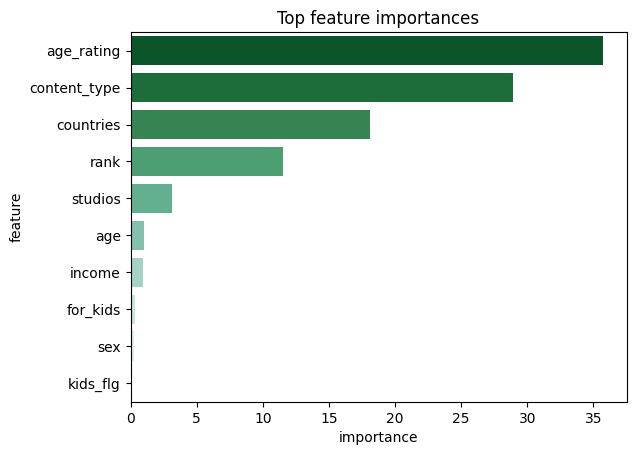

In [38]:
'''

Visualise the feature importances of features

'''

imp_catboost = pd.DataFrame(X_train.columns, columns = ['feature'])
imp_catboost['importance'] = ctb_model.feature_importances_

sns.barplot(data=imp_catboost.sort_values(by='importance', ascending=False), x='importance', y='feature', palette="BuGn_r")
plt.title('Top feature importances');

### <b><span style='color:#686dec'>Проверяем качество Модели 2 этапа на отложенной выборке</span></b>

In [39]:
'''

Prepare Test Set

'''

test_feat = (ctb_test
             .merge(users[user_col], on=['user_id'], how='left')
             .merge(items[item_col], on=['item_id'], how='left'))

# fillna for catboost with the most frequent value
test_feat = test_feat.fillna(X_train.mode().iloc[0])

X_test, y_test = test_feat.drop(drop_col + target_col, axis=1), test_feat['target']

'''

Make prediction on test set

'''

y_pred = ctb_model.predict_proba(X_test)
f"ROC AUC score = {roc_auc_score(y_test, y_pred[:, 1]):.2f}"

'ROC AUC score = 0.77'

## <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#232834"><b><span style='color:#686dec'>7 |</span></b> <b>Метрики качества на глобальном test</b></div>


- Формируем рекомендации отдельно моделью 1 этапа - bpr
- Отдельно двухэтапной моделью bpr + Catboost
- Сравниваем

### <b><span style='color:#686dec'>Метрики качества bpr</span></b>

In [40]:
'''

Global Test [test] 

'''

# group [item_id] for each [user_id] in test (main test)
test = test[test['user_id'].isin(val['user_id'].unique())] # test user_id must contain val user_id
test_user_history = test.groupby('user_id')[['item_id']].agg(lambda x: list(x))
display(test_user_history.head())

,item_id
user_id,
21,"[13787, 14488]"
30,"[4181, 8584, 8636]"
98,"[89, 512]"
106,"[337, 1439, 2808, 2836, 5411, 6267, 10544, 128..."
241,"[6162, 8986, 10440, 12138]"


In [41]:
'''

(1) User first model for prediction of recommendations for [test] set

'''

# first model prediction for k=100
pred_bpr = predict(user_vecs, item_vecs, k=100)
pred_bpr = test_user_history.merge(pred_bpr, how='left', on='user_id')
display(pred_bpr.head()) # overlap b/w [train] (user_vect/item_vecs) prediction and test set (item_id)

# determine overlapping metrics b/w test and train
print('recall',round(recall(pred_bpr, k=20),3))
print('precision',round(precision(pred_bpr, k=20),3))
print('mrr',round(mrr(pred_bpr, k=20),3))

,user_id,item_id,preds
0,21,"[13787, 14488]","[849, 24, 1053, 11237, 14703, 8636, 12659, 496..."
1,30,"[4181, 8584, 8636]","[142, 16201, 13865, 10440, 4880, 1465, 2303, 1..."
2,98,"[89, 512]","[2786, 16201, 14337, 4350, 11402, 14053, 12994..."
3,106,"[337, 1439, 2808, 2836, 5411, 6267, 10544, 128...","[16166, 14942, 16270, 3632, 11539, 15084, 1522..."
4,241,"[6162, 8986, 10440, 12138]","[13653, 16174, 2823, 7571, 13018, 7889, 16166,..."


recall 0.044
precision 0.044
mrr 0.023


In [42]:
'''

(1a) Improve the first model factorisation parameter (k=100)

'''

# генерируем предказания от первой модели (k=100)
pred_bpr = pred_bpr[['user_id', 'preds']] 
pred_bpr = pred_bpr.explode('preds').rename(columns={'preds': 'item_id'})
pred_bpr['rank'] = pred_bpr.groupby('user_id').cumcount() + 1 # give rank to each item_id order
pred_bpr.head()

,user_id,item_id,rank
0,21,849,1
0,21,24,2
0,21,1053,3
0,21,11237,4
0,21,14703,5


### <b><span style='color:#686dec'>Метрики качества двухэтапной модели: `bpr` + `Catboost`</span></b>

- `pred_bpr` contains predictions from first model with k=100
- Add user and item based features to recommendations from first model
- Use 2nd stage model, trained on validation set `val` to get probability of positive class (`ctb_pred`)

In [43]:
'''

(2a) Prepare the dataset for the second model prediction

'''

pred_bpr_ctb = pred_bpr.copy()

# фичи для теста
score_feat = (pred_bpr_ctb
              .merge(users[user_col], on=['user_id'], how='left')
              .merge(items[item_col], on=['item_id'], how='left'))

# fillna for catboost with the most frequent value
score_feat = score_feat.fillna(X_train.mode().iloc[0])
score_feat.head()

,user_id,item_id,rank,age,income,sex,kids_flg,content_type,countries,for_kids,age_rating,studios
0,21,849,1,age_45_54,income_20_40,Ж,0.0,film,США,0.0,18.0,HBO
1,21,24,2,age_45_54,income_20_40,Ж,0.0,series,Германия,0.0,16.0,HBO
2,21,1053,3,age_45_54,income_20_40,Ж,0.0,film,США,0.0,18.0,HBO
3,21,11237,4,age_45_54,income_20_40,Ж,0.0,film,Россия,0.0,16.0,HBO
4,21,14703,5,age_45_54,income_20_40,Ж,0.0,film,США,0.0,18.0,HBO


In [44]:
'''

(2b) User second model; trained on validation dataset 

'''

ctb_prediction = ctb_model.predict_proba(score_feat.drop(drop_col, axis=1, errors='ignore'))

pred_bpr_ctb['ctb_pred'] = ctb_prediction[:, 1] # prob for positive class
pred_bpr_ctb.head(3)

,user_id,item_id,rank,ctb_pred
0,21,849,1,0.269009
0,21,24,2,0.228995
0,21,1053,3,0.261176


- Проставляем итоговый ранк двухэтапной модели `rank_ctb`

In [45]:
# сортируем по скору внутри одного пользователя и проставляем новый ранг
pred_bpr_ctb = pred_bpr_ctb.sort_values(
                                        by=['user_id', 'ctb_pred'], 
                                        ascending=[True, False])
pred_bpr_ctb['rank_ctb'] = pred_bpr_ctb.groupby('user_id').cumcount() + 1
pred_bpr_ctb.head()

,user_id,item_id,rank,ctb_pred,rank_ctb
0,21,11237,4,0.481346,1
0,21,8636,6,0.370781,2
0,21,11661,9,0.350955,3
0,21,496,8,0.336498,4
0,21,8252,36,0.289617,5


Подсчет метрик прексказания перврой + второй модели относительно просморов в те товой ыыборке

In [46]:
'''

1+2 этапы bpr + Сatboost: Метрики

'''

true_items = test.groupby('user_id').agg(lambda x: list(x))[['item_id']].reset_index()
pred_items = pred_bpr_ctb.groupby('user_id').agg(lambda x: list(x))[['item_id']].reset_index().rename(columns={'item_id': 'preds'})
true_pred_items = true_items.merge(pred_items, how='left')
true_pred_items.head()

,user_id,item_id,preds
0,21,"[13787, 14488]","[11237, 8636, 11661, 496, 8252, 12701, 10313, ..."
1,30,"[4181, 8584, 8636]","[1465, 4880, 10440, 4151, 14192, 15297, 1261, ..."
2,98,"[89, 512]","[14192, 16201, 7829, 1299, 12346, 5648, 10152,..."
3,106,"[337, 1439, 2808, 2836, 5411, 6267, 10544, 128...","[16166, 7571, 14942, 11539, 13243, 3632, 3834,..."
4,241,"[6162, 8986, 10440, 12138]","[16174, 7571, 13018, 16166, 5979, 242, 13913, ..."


In [47]:
print('recall',round(recall(true_pred_items, k=20),3))
print('precision',round(precision(true_pred_items, k=20),3))
print('mrr',round(mrr(true_pred_items, k=20),3))

recall 0.055
precision 0.055
mrr 0.033
